### APPROACH 1

In my project, I encountered the challenge of working with two distinct datasets: one classified images by gender (male/female), and the other by emotion (happy/sad). To effectively train a model capable of predicting all four required classes - HappyMale, HappyFemale, SadMale, SadFemale - I devised a unique strategy.

Initially, I developed two separate models. The first model was trained exclusively on the gender dataset, while the second focused on the emotion dataset. The key to integrating these datasets lay in cross-utilizing the models for predictions. I used the emotion model to predict the emotional states (happy or sad) of the images in the gender dataset. Conversely, I applied the gender model to the emotion dataset to determine the gender (male or female) of each image.

By combining these newly predicted labels with the existing labels, I was able to construct a comprehensive dataset encompassing all four desired categories. This amalgamated dataset, containing the refined classifications, served as the foundation for training a final, more robust model that could accurately predict the categories of HappyMale, HappyFemale, SadMale, and SadFemale. This approach not only enhanced the accuracy of the predictions but also streamlined the process of handling disparate datasets in a unified manner.

!pip install numpy opencv-python-headless h5py matplotlib scikit-learn tensorflow pandas seaborn


I am assuming that the datasets provided are unzipped

In [1]:
# Standard library imports
import os
import random

# Third-party library imports
import numpy as np
import cv2
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, AveragePooling2D, 
                                     Flatten, Dense, Dropout)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam


### Helper Functions

In [2]:

# Function to load gender images
def load_gender_images(dataset_path, folder):
    """
    Loads gender images
    
    """
    data = []
    labels = []
    for gender in ["male", "female"]:
        gender_path = os.path.join(dataset_path, folder, gender)
        for img_file in os.listdir(gender_path):
            img_path = os.path.join(gender_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (64, 64))
            data.append(img)
            labels.append(gender)
    return np.array(data), np.array(labels)


def load_emotion_images(file_path, train_test):
    """
    Loads emotion images
    
    """
    dataset = h5py.File(file_path, "r")
    data = np.array(dataset[train_test+'_set_x'][:])
    labels = np.array(dataset[train_test+'_set_y'][:])
    labels = np.where(labels == 0, 'Sad', 'Happy')
    return data, labels



def create_lenet5_model(num_classes):
    """
    Creates Lenet-5 model architecture for gender classification with dropouts to prevent overfitting
    """
    model = Sequential()

    # First set of CONV => ACTIVATION => POOL layers
    model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(64, 64, 3), padding="same"))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Second set of CONV => ACTIVATION => POOL layers
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten the network
    model.add(Flatten())

    # First FC layer
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(0.5))

    # Second FC layer
    model.add(Dense(84, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer with softmax activation
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model




In [3]:
# Load and preprocess the datasets

gender_data, gender_labels = load_gender_images('male-female', 'Training')
emotion_data, emotion_labels = load_emotion_images('happy/train_happy.h5','train')



In [4]:
len(gender_labels),len(gender_data)

(47009, 47009)

In [5]:
len(emotion_labels),len(emotion_data)

(600, 600)

In [6]:
# Encode labels
le_gender = LabelEncoder()
gender_labels_encoded = le_gender.fit_transform(gender_labels)
gender_labels_categorical = to_categorical(gender_labels_encoded, 2)

le_emotion = LabelEncoder()
emotion_labels_encoded = le_emotion.fit_transform(emotion_labels)
emotion_labels_categorical = to_categorical(emotion_labels_encoded, 2)



In [7]:
len(gender_labels_categorical),len(emotion_labels_categorical)

(47009, 600)

In [8]:
gender_labels

array(['male', 'male', 'male', ..., 'female', 'female', 'female'],
      dtype='<U6')

In [9]:
emotion_labels

array(['Sad', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Sad', 'Sad',
       'Sad', 'Happy', 'Sad', 'Sad', 'Happy', 'Happy', 'Happy', 'Happy',
       'Happy', 'Sad', 'Sad', 'Sad', 'Sad', 'Happy', 'Happy', 'Sad',
       'Happy', 'Sad', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy',
       'Happy', 'Sad', 'Happy', 'Sad', 'Happy', 'Sad', 'Sad', 'Happy',
       'Happy', 'Happy', 'Sad', 'Happy', 'Sad', 'Happy', 'Happy', 'Sad',
       'Happy', 'Sad', 'Happy', 'Happy', 'Sad', 'Happy', 'Sad', 'Sad',
       'Sad', 'Sad', 'Happy', 'Sad', 'Happy', 'Happy', 'Happy', 'Sad',
       'Happy', 'Happy', 'Happy', 'Happy', 'Sad', 'Happy', 'Sad', 'Happy',
       'Happy', 'Sad', 'Happy', 'Happy', 'Sad', 'Happy', 'Happy', 'Happy',
       'Sad', 'Happy', 'Happy', 'Sad', 'Sad', 'Sad', 'Sad', 'Happy',
       'Sad', 'Happy', 'Sad', 'Happy', 'Happy', 'Sad', 'Sad', 'Happy',
       'Happy', 'Sad', 'Happy', 'Happy', 'Sad', 'Happy', 'Sad', 'Happy',
       'Sad', 'Sad', 'Happy', 'Sad', 'Sad', 'Happy', 'Happy', 'Happy

In [10]:
# Split the datasets
X_gender_train, X_gender_val, y_gender_train, y_gender_val = train_test_split(gender_data, gender_labels_categorical, test_size=0.2, random_state=42)
X_emotion_train, X_emotion_val, y_emotion_train, y_emotion_val = train_test_split(emotion_data, emotion_labels_categorical, test_size=0.2, random_state=42)





In [11]:
len(X_gender_train), len(X_gender_val), len(y_gender_train), len(y_gender_val)

(37607, 9402, 37607, 9402)

In [12]:
len(X_emotion_train), len(X_emotion_val), len(y_emotion_train), len(y_emotion_val)

(480, 120, 480, 120)

In [13]:
# Create, train, and save the gender model

gender_model = create_lenet5_model(num_classes=2)
gender_model.fit(X_gender_train, y_gender_train, epochs=10, batch_size=32, validation_data=(X_gender_val, y_gender_val))
gender_model.save('gender_le5_model.h5')




Epoch 1/10
1176/1176 [==============================] - 17s 14ms/step - loss: 0.5916 - accuracy: 0.7975 - val_loss: 0.2763 - val_accuracy: 0.8850
Epoch 2/10
1176/1176 [==============================] - 17s 15ms/step - loss: 0.2768 - accuracy: 0.8932 - val_loss: 0.2388 - val_accuracy: 0.9080
Epoch 3/10
1176/1176 [==============================] - 18s 15ms/step - loss: 0.2429 - accuracy: 0.9079 - val_loss: 0.2033 - val_accuracy: 0.9272
Epoch 4/10
1176/1176 [==============================] - 21s 17ms/step - loss: 0.2246 - accuracy: 0.9172 - val_loss: 0.1775 - val_accuracy: 0.9359
Epoch 5/10
1176/1176 [==============================] - 20s 17ms/step - loss: 0.2096 - accuracy: 0.9232 - val_loss: 0.1911 - val_accuracy: 0.9293
Epoch 6/10
1176/1176 [==============================] - 21s 18ms/step - loss: 0.1967 - accuracy: 0.9282 - val_loss: 0.1736 - val_accuracy: 0.9348
Epoch 7/10
1176/1176 [==============================] - 21s 18ms/step - loss: 0.1830 - accuracy: 0.9343 - val_loss: 0.1675 -

/Users/rishabhindoria/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# Create, train, and save the emotion model
emotion_model = create_lenet5_model(num_classes=2)
emotion_model.fit(X_emotion_train, y_emotion_train, epochs=10, batch_size=32, validation_data=(X_emotion_val, y_emotion_val))
emotion_model.save('emotion_le5_model.h5')



Epoch 1/10
15/15 [==============================] - 1s 23ms/step - loss: 8.4021 - accuracy: 0.5271 - val_loss: 0.7006 - val_accuracy: 0.4750
Epoch 2/10
15/15 [==============================] - 0s 19ms/step - loss: 0.7211 - accuracy: 0.5854 - val_loss: 0.6660 - val_accuracy: 0.5583
Epoch 3/10
15/15 [==============================] - 0s 19ms/step - loss: 0.6412 - accuracy: 0.6458 - val_loss: 0.6165 - val_accuracy: 0.7417
Epoch 4/10
15/15 [==============================] - 0s 22ms/step - loss: 0.5559 - accuracy: 0.7542 - val_loss: 0.5223 - val_accuracy: 0.7917
Epoch 5/10
15/15 [==============================] - 0s 21ms/step - loss: 0.5043 - accuracy: 0.7417 - val_loss: 0.4380 - val_accuracy: 0.8083
Epoch 6/10
15/15 [==============================] - 0s 24ms/step - loss: 0.4044 - accuracy: 0.8375 - val_loss: 0.3654 - val_accuracy: 0.8250
Epoch 7/10
15/15 [==============================] - 0s 23ms/step - loss: 0.2466 - accuracy: 0.9000 - val_loss: 0.2912 - val_accuracy: 0.8917
Epoch 8/10
15

In [15]:
# Load models for cross-predictions
gender_model = load_model('gender_le5_model.h5')
emotion_model = load_model('emotion_le5_model.h5')

In [16]:
# Predict gender on emotion dataset
gender_predictions = gender_model.predict(X_emotion_train)
gender_predicted_labels = np.argmax(gender_predictions, axis=1)
gender_predicted_labels = le_gender.inverse_transform(gender_predicted_labels)



15/15 [==============================] - 0s 6ms/step


In [17]:
len(gender_predicted_labels)

480

In [18]:
gender_predicted_labels

array(['male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
      

In [19]:
# Predict emotion on gender dataset
emotion_predictions = emotion_model.predict(X_gender_train)
emotion_predicted_labels = np.argmax(emotion_predictions, axis=1)
emotion_predicted_labels = le_emotion.inverse_transform(emotion_predicted_labels)



1176/1176 [==============================] - 7s 6ms/step


In [20]:
len(emotion_predicted_labels)

37607

In [21]:
emotion_predicted_labels

array(['Happy', 'Happy', 'Happy', ..., 'Happy', 'Happy', 'Happy'],
      dtype='<U5')

In [22]:
np.unique(emotion_predicted_labels)

array(['Happy', 'Sad'], dtype='<U5')

In [23]:
reversed_emotion_train_labels = np.argmax(y_emotion_train, axis=1)
reversed_emotion_train_labels_original = le_emotion.inverse_transform(reversed_emotion_train_labels)


In [24]:
reversed_emotion_train_labels_original

array(['Happy', 'Happy', 'Sad', 'Happy', 'Sad', 'Sad', 'Happy', 'Happy',
       'Happy', 'Happy', 'Sad', 'Sad', 'Happy', 'Sad', 'Sad', 'Happy',
       'Sad', 'Sad', 'Happy', 'Happy', 'Happy', 'Sad', 'Sad', 'Happy',
       'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Sad', 'Happy', 'Sad',
       'Happy', 'Happy', 'Sad', 'Sad', 'Happy', 'Sad', 'Sad', 'Sad',
       'Sad', 'Sad', 'Sad', 'Happy', 'Happy', 'Happy', 'Sad', 'Sad',
       'Sad', 'Sad', 'Sad', 'Happy', 'Sad', 'Happy', 'Happy', 'Sad',
       'Sad', 'Sad', 'Sad', 'Happy', 'Happy', 'Sad', 'Sad', 'Happy',
       'Happy', 'Happy', 'Happy', 'Sad', 'Happy', 'Sad', 'Sad', 'Happy',
       'Sad', 'Happy', 'Happy', 'Sad', 'Sad', 'Happy', 'Sad', 'Happy',
       'Sad', 'Sad', 'Sad', 'Happy', 'Happy', 'Sad', 'Happy', 'Sad',
       'Sad', 'Sad', 'Sad', 'Happy', 'Sad', 'Happy', 'Happy', 'Sad',
       'Happy', 'Sad', 'Happy', 'Sad', 'Happy', 'Sad', 'Sad', 'Happy',
       'Sad', 'Sad', 'Sad', 'Happy', 'Happy', 'Sad', 'Sad', 'Sad', 'Sad',
       

In [25]:
len(reversed_emotion_train_labels_original)

480

In [26]:
reversed_gender_train_labels = np.argmax(y_gender_train, axis=1)
reversed_gender_train_labels_original = le_gender.inverse_transform(reversed_gender_train_labels)


In [27]:
reversed_gender_train_labels_original

array(['female', 'male', 'male', ..., 'female', 'male', 'male'],
      dtype='<U6')

In [28]:
len(reversed_gender_train_labels_original)

37607

In [29]:
# Combine and save the new labels
combined_labels_emotion_dataset = ['{}_{}'.format(emotion, gender) for emotion, gender in zip(reversed_emotion_train_labels_original, gender_predicted_labels)]
combined_labels_gender_dataset = ['{}_{}'.format(emotion, gender ) for emotion, gender  in zip(emotion_predicted_labels, reversed_gender_train_labels_original)]


In [30]:
len(combined_labels_emotion_dataset)

480

In [31]:
combined_labels_emotion_dataset

['Happy_male',
 'Happy_male',
 'Sad_male',
 'Happy_male',
 'Sad_male',
 'Sad_male',
 'Happy_male',
 'Happy_male',
 'Happy_male',
 'Happy_male',
 'Sad_male',
 'Sad_male',
 'Happy_male',
 'Sad_male',
 'Sad_male',
 'Happy_male',
 'Sad_male',
 'Sad_male',
 'Happy_male',
 'Happy_male',
 'Happy_male',
 'Sad_male',
 'Sad_male',
 'Happy_male',
 'Happy_male',
 'Happy_male',
 'Happy_male',
 'Happy_male',
 'Happy_male',
 'Sad_male',
 'Happy_male',
 'Sad_male',
 'Happy_male',
 'Happy_male',
 'Sad_male',
 'Sad_male',
 'Happy_male',
 'Sad_male',
 'Sad_male',
 'Sad_male',
 'Sad_male',
 'Sad_male',
 'Sad_male',
 'Happy_male',
 'Happy_male',
 'Happy_male',
 'Sad_male',
 'Sad_male',
 'Sad_male',
 'Sad_male',
 'Sad_male',
 'Happy_male',
 'Sad_male',
 'Happy_male',
 'Happy_male',
 'Sad_male',
 'Sad_male',
 'Sad_male',
 'Sad_male',
 'Happy_male',
 'Happy_male',
 'Sad_male',
 'Sad_male',
 'Happy_male',
 'Happy_male',
 'Happy_male',
 'Happy_male',
 'Sad_male',
 'Happy_male',
 'Sad_male',
 'Sad_male',
 'Happy

In [32]:
len(combined_labels_gender_dataset)

37607

In [33]:
combined_labels_gender_dataset

['Happy_female',
 'Happy_male',
 'Happy_male',
 'Happy_male',
 'Sad_male',
 'Happy_male',
 'Happy_female',
 'Sad_male',
 'Happy_female',
 'Happy_female',
 'Sad_female',
 'Sad_male',
 'Sad_female',
 'Happy_male',
 'Sad_male',
 'Happy_female',
 'Happy_male',
 'Sad_male',
 'Sad_female',
 'Happy_male',
 'Sad_female',
 'Happy_male',
 'Happy_female',
 'Happy_male',
 'Happy_female',
 'Happy_male',
 'Sad_female',
 'Happy_male',
 'Happy_female',
 'Happy_male',
 'Happy_male',
 'Sad_male',
 'Happy_male',
 'Happy_male',
 'Happy_female',
 'Happy_male',
 'Happy_male',
 'Happy_male',
 'Happy_female',
 'Sad_male',
 'Happy_male',
 'Sad_female',
 'Sad_male',
 'Happy_male',
 'Happy_male',
 'Happy_female',
 'Sad_male',
 'Sad_female',
 'Happy_female',
 'Happy_male',
 'Happy_female',
 'Happy_female',
 'Happy_male',
 'Happy_female',
 'Happy_male',
 'Sad_male',
 'Happy_male',
 'Happy_male',
 'Happy_female',
 'Happy_male',
 'Happy_female',
 'Happy_female',
 'Happy_male',
 'Happy_female',
 'Happy_male',
 'Happy

Saving the new datasets in .h5 format with the newly created combined labels

In [34]:

combined_labels_emotion_array = np.array(combined_labels_emotion_dataset)
combined_labels_emotion_encoded = np.array(combined_labels_emotion_array).astype('S')  # Convert to byte strings

# Save the datasets
with h5py.File('predicted_emotion_dataset.h5', 'w') as h5f:
    h5f.create_dataset('data_emotion', data=X_emotion_train)  # Your image data
    h5f.create_dataset('labels_emotion', data=combined_labels_emotion_encoded)


In [35]:
len(combined_labels_emotion_encoded)

480

In [36]:
with h5py.File('predicted_emotion_dataset.h5', 'r') as h5f:
    # Load the data
    data_emotion = h5f['data_emotion'][:]

    # Load the labels
    labels_emotion = h5f['labels_emotion'][:]


# convert labels back to strings
labels_emotion = [label.decode('utf-8') for label in labels_emotion]

print("Data loaded successfully")


Data loaded successfully


In [37]:
len(labels_emotion),len(data_emotion)

(480, 480)

In [38]:

combined_labels_gender_array = np.array(combined_labels_gender_dataset)
combined_labels_gender_encoded = np.array(combined_labels_gender_array).astype('S')  # Convert to byte strings

# Save the datasets
with h5py.File('predicted_gender_dataset.h5', 'w') as h5f:
    h5f.create_dataset('data_gender', data=X_gender_train)  # Your image data
    h5f.create_dataset('labels_gender', data=combined_labels_gender_encoded)


In [39]:
with h5py.File('predicted_gender_dataset.h5', 'r') as h5f:
    # Load the data
    data_gender = h5f['data_gender'][:]

    # Load the labels
    labels_gender = h5f['labels_gender'][:]

# convert labels back to strings
labels_gender = [label.decode('utf-8') for label in labels_gender]

print("Data loaded successfully")


Data loaded successfully


In [40]:
len(data_gender),len(data_emotion)

(37607, 480)

In [41]:
len(labels_gender),len(labels_emotion)

(37607, 480)

In [42]:


# Concatenate the data and labels from both emotion and gender datasets
merged_data = np.concatenate((data_gender, data_emotion), axis=0)
merged_labels = np.concatenate((labels_gender, labels_emotion), axis=0)


In [43]:

merged_labels_array = np.array(merged_labels)

merged_labels_array_encoded = np.array(merged_labels_array).astype('S') 

# Save the merged datasets
with h5py.File('predicted_merged_dataset.h5', 'w') as h5f:
    h5f.create_dataset('data', data=merged_data)
    h5f.create_dataset('labels', data=merged_labels_array_encoded)

print("Merged dataset saved as predicted_merged_dataset.h5")


Merged dataset saved as predicted_merged_dataset.h5


In [44]:
with h5py.File('predicted_merged_dataset.h5', 'r') as h5f:
    # Load the data
    data = h5f['data'][:]

    # Load the labels
    labels = h5f['labels'][:]

labels = [label.decode('utf-8') for label in labels]

print("Data loaded successfully")


Data loaded successfully


In [45]:
len(data)

38087

In [46]:
len(labels)

38087

In [47]:
# Encode labels
le_merged = LabelEncoder()
merged_labels_encoded = le_merged.fit_transform(labels)
merged_labels_categorical = to_categorical(merged_labels_encoded, 4)


In [48]:
merged_labels_categorical

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [49]:

# Split the datasets
X_merged_train, X_merged_val, y_merged_train, y_merged_val = train_test_split(data, merged_labels_categorical, test_size=0.2, random_state=42)

# Create, train, and save the merged model
merged_model = create_lenet5_model(num_classes=4)
history_merged = merged_model.fit(X_merged_train, y_merged_train, epochs=20, batch_size=32, validation_data=(X_merged_val, y_merged_val))
merged_model.save('merged_le5_model.h5')




Epoch 1/20
953/953 [==============================] - 18s 19ms/step - loss: 1.2467 - accuracy: 0.5884 - val_loss: 0.7906 - val_accuracy: 0.6852
Epoch 2/20
953/953 [==============================] - 17s 18ms/step - loss: 0.8019 - accuracy: 0.6818 - val_loss: 0.7194 - val_accuracy: 0.7085
Epoch 3/20
953/953 [==============================] - 17s 17ms/step - loss: 0.7133 - accuracy: 0.7145 - val_loss: 0.6269 - val_accuracy: 0.7530
Epoch 4/20
953/953 [==============================] - 17s 17ms/step - loss: 0.6609 - accuracy: 0.7337 - val_loss: 0.6092 - val_accuracy: 0.7636
Epoch 5/20
953/953 [==============================] - 17s 17ms/step - loss: 0.6313 - accuracy: 0.7462 - val_loss: 0.5567 - val_accuracy: 0.7679
Epoch 6/20
953/953 [==============================] - 16s 17ms/step - loss: 0.5875 - accuracy: 0.7623 - val_loss: 0.5598 - val_accuracy: 0.7745
Epoch 7/20
953/953 [==============================] - 16s 17ms/step - loss: 0.5701 - accuracy: 0.7693 - val_loss: 0.5334 - val_accuracy:

/Users/rishabhindoria/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [50]:

def plot_model_performance(history):
    """
    Function to plot the performance of the model on training and validation data.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

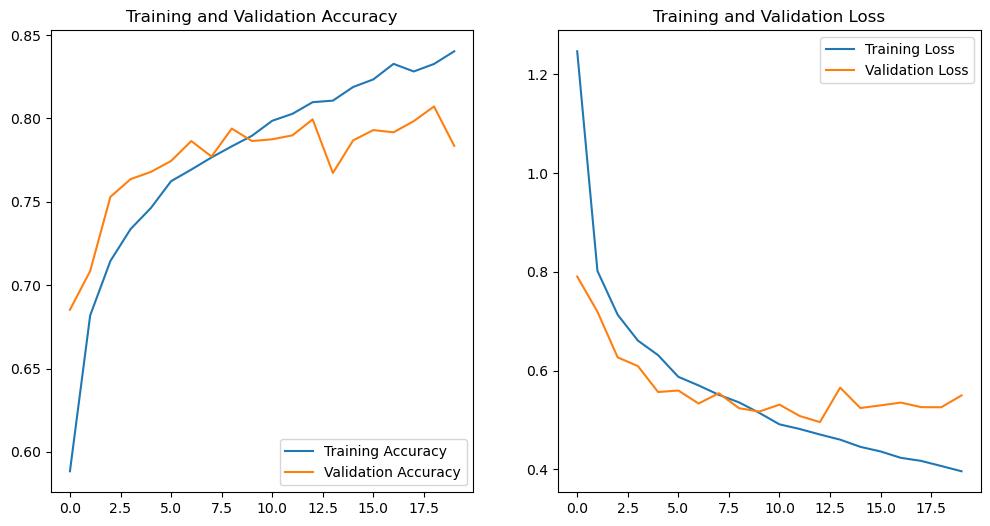

In [51]:
# Plot model performance
plot_model_performance(history_merged)

In [52]:
# Load and preprocess the test datasets

gender_test_data, gender_test_labels = load_gender_images('male-female', 'Validation')
emotion_test_data, emotion_test_labels = load_emotion_images('happy/test_happy.h5','test')



In [53]:
from sklearn.utils import shuffle
merged_test_images = np.concatenate((gender_test_data, emotion_test_data))
merged_test_images = shuffle(merged_test_images, random_state=42)

In [54]:
len(merged_test_images)

11799

In [55]:
# Predict final labels on merged dataset
merged_predictions = merged_model.predict(merged_test_images)
merged_predicted_labels = np.argmax(merged_predictions, axis=1)
merged_predicted_labels = le_merged.inverse_transform(merged_predicted_labels)


369/369 [==============================] - 2s 6ms/step


In [56]:
merged_predicted_labels

array(['Happy_female', 'Happy_male', 'Happy_female', ..., 'Happy_male',
       'Happy_male', 'Happy_female'], dtype='<U12')

In [57]:


def display_predictions(images, predicted_labels):
    """
    Get 25 random indices from the range of available images and then display it with the predicted labels
    """
    plt.figure(figsize=(10, 10))
    
    random_indices = random.sample(range(len(images)), 25)
    for i, idx in enumerate(random_indices):  # Display 25 random images
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[idx])
        plt.xlabel(f'Pred: {predicted_labels[idx]}')
    plt.show()


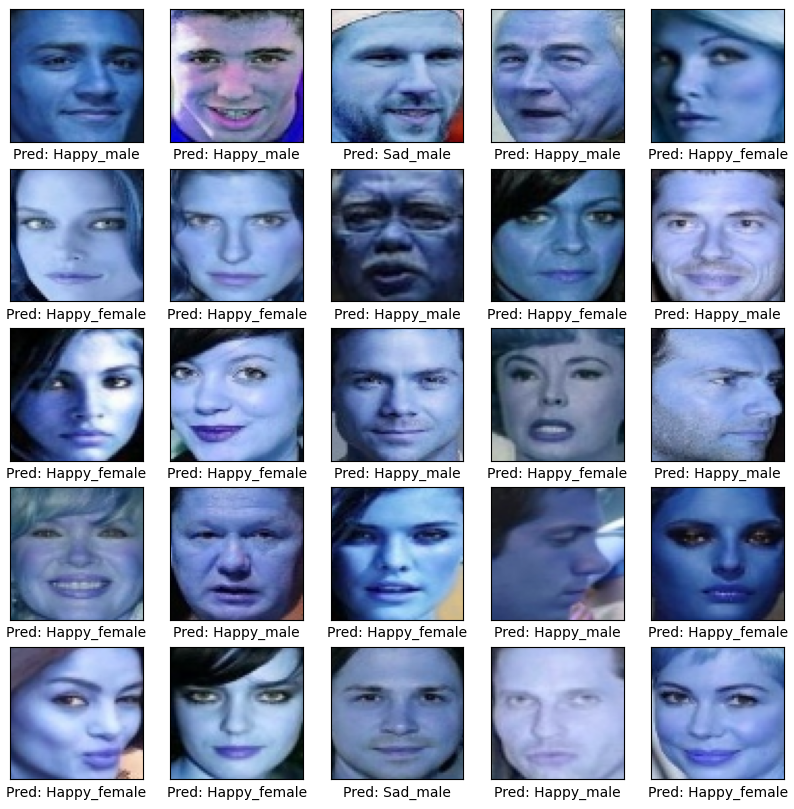

In [58]:
display_predictions(merged_test_images, merged_predicted_labels)

### APPROACH 2

In my approach, I chose a different strategy from cross prediction, focusing instead on refining and merging the given datasets. Recognizing the limited data available for emotion classification, I made a deliberate decision to balance the dataset. This involved selecting an equal number of images from each category, ensuring a fair representation across all classes.

To enhance the diversity and randomness within the dataset, I implemented shuffling. This step was crucial in preventing any biases or patterns that might arise from the original ordering of the images. By meticulously curating and shuffling the data, I aimed to create a more robust and unbiased dataset, which is essential for training a model that can accurately generalize across various inputs. This methodical approach was key in addressing the challenges posed by the limited data and in ensuring a well-rounded dataset for effective model training.

In [59]:
import cv2
import h5py
import numpy as np
import os
import pandas as pd
import seaborn as sns
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical


#### Helper functions

In [60]:


# Function to load gender images
def load_gender_images(dataset_path, folder):
    data = []
    labels = []
    for gender in ["male", "female"]:
        gender_path = os.path.join(dataset_path, folder, gender)
        for img_file in os.listdir(gender_path):
            img_path = os.path.join(gender_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (64, 64))
            data.append(img)
            labels.append(gender)
    return np.array(data), np.array(labels)

# Function to load emotion images
def load_emotion_images(file_path, train_test):
    dataset = h5py.File(file_path, "r")
    data = np.array(dataset[train_test+'_set_x'][:])
    labels = np.array(dataset[train_test+'_set_y'][:])
    labels = np.where(labels == 0, 'Sad', 'Happy')
    return data, labels




# EDA functions
def plot_sample_images(data, labels, title):
    plt.figure(figsize=(10, 10))
    for i in range(25):  # Display first 25 images
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(data[i])
        plt.xlabel(labels[i])
    plt.suptitle(title)
    plt.show()

def plot_label_distribution(labels, title):
# Count the occurrences of each label
    label_counts = Counter(train_labels_decoded)

    # Create a bar plot
    plt.bar(label_counts.keys(), label_counts.values())
    plt.title('Training Data Label Distribution')
    plt.xticks(rotation=45)  # Rotate labels if they are overlapping
    plt.ylabel('Frequency')
    plt.show()
    
def prepare_datasets(gender_data, gender_labels, emotion_data, emotion_labels, test_size=0.2, random_state=42):
    # Shuffle each dataset
    gender_data, gender_labels = shuffle(gender_data, gender_labels, random_state=random_state)
    emotion_data, emotion_labels = shuffle(emotion_data, emotion_labels, random_state=random_state)

    # Normalize the image data
    gender_data = gender_data / 255.0
    emotion_data = emotion_data / 255.0

    # Truncate the datasets to the same size
    min_size = min(len(gender_data), len(emotion_data))
    gender_data = gender_data[:min_size]
    gender_labels = gender_labels[:min_size]
    emotion_data = emotion_data[:min_size]
    emotion_labels = emotion_labels[:min_size]

    # Combine data and labels
    combined_data = gender_data  # Using gender_data as the main dataset
    combined_labels = np.array([f'{emotion}{gender.capitalize()}' for emotion, gender in zip(emotion_labels, gender_labels)])

    # Encode labels
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(combined_labels)
    categorical_labels = to_categorical(encoded_labels, num_classes=4)

    # Shuffle combined dataset
    combined_data, categorical_labels = shuffle(combined_data, categorical_labels, random_state=random_state)

    # Split dataset into training and validation sets
    train_data, val_data, train_labels, val_labels = train_test_split(combined_data, categorical_labels, test_size=test_size, random_state=random_state)

    return train_data, val_data, train_labels, val_labels, encoder


def prepare_test_dataset(gender_data, gender_labels, emotion_data, emotion_labels, random_state=42):
    # Shuffle each dataset
    gender_data, gender_labels = shuffle(gender_data, gender_labels, random_state=random_state)
    emotion_data, emotion_labels = shuffle(emotion_data, emotion_labels, random_state=random_state)

    # Normalize the image data
    gender_data = gender_data / 255.0
    emotion_data = emotion_data / 255.0

    # Truncate the datasets to the same size
    min_size = min(len(gender_data), len(emotion_data))
    gender_data = gender_data[:min_size]
    gender_labels = gender_labels[:min_size]
    emotion_data = emotion_data[:min_size]
    emotion_labels = emotion_labels[:min_size]

    # Combine data and labels
    combined_data = gender_data  # Using gender_data as the main dataset
    combined_labels = np.array([f'{emotion}{gender.capitalize()}' for emotion, gender in zip(emotion_labels, gender_labels)])

    # Encode labels
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(combined_labels)
    categorical_labels = to_categorical(encoded_labels, num_classes=4)

    # Shuffle combined dataset
    combined_data, categorical_labels = shuffle(combined_data, categorical_labels, random_state=random_state)

    return combined_data, categorical_labels, encoder


def predict(model, test_data):
    predictions = model.predict(test_data)
    return np.argmax(predictions, axis=1)

# Display images with predicted labels
def display_predictions(images, predicted_labels):
    plt.figure(figsize=(10, 10))
    for i in range(25):  # Display first 25 images
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(f'Pred: {predicted_labels[i]}')
    plt.show()



In [61]:
# Load datasets
gender_data, gender_labels = load_gender_images('male-female', 'Training')
emotion_data, emotion_labels = load_emotion_images('happy/train_happy.h5','train')
train_data, val_data, train_labels, val_labels, encoder_train= prepare_datasets(gender_data, gender_labels, emotion_data, emotion_labels, test_size=0.2, random_state=42)

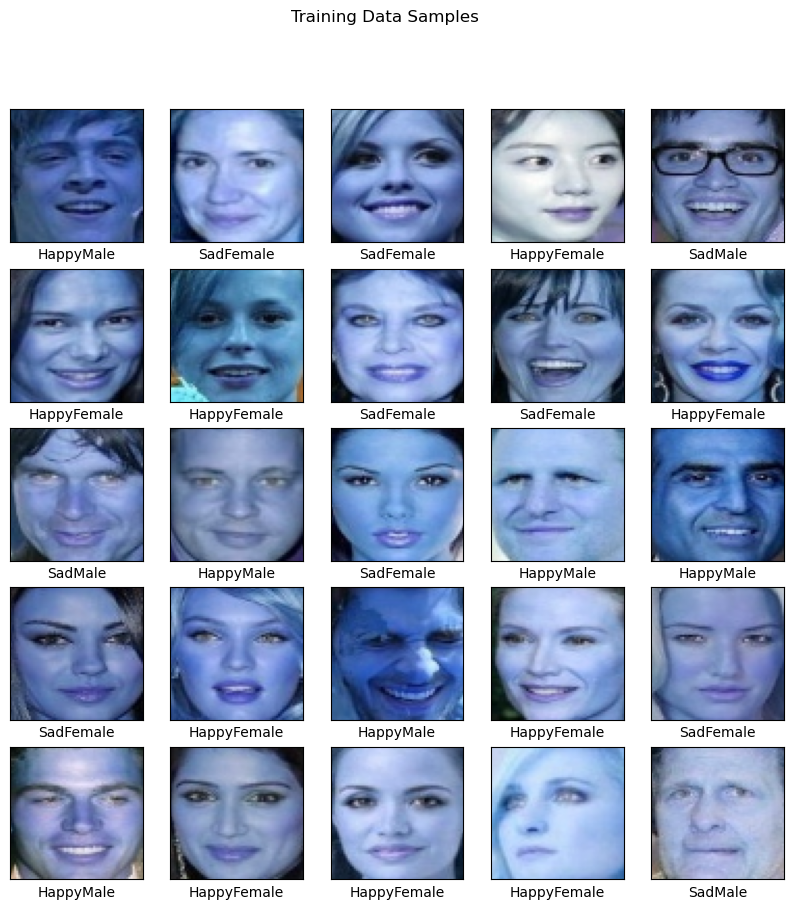

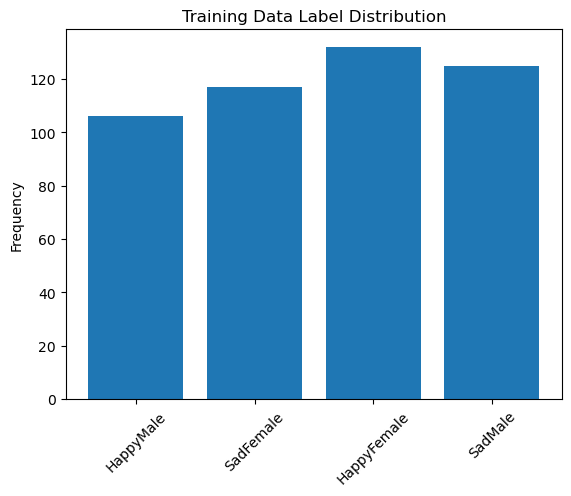

In [62]:
# EDA of Training Data
train_labels_decoded = [encoder_train.classes_[np.argmax(label)] for label in train_labels]
plot_sample_images(train_data, train_labels_decoded, 'Training Data Samples')
plot_label_distribution(train_labels_decoded, 'Training Data Label Distribution')

In [63]:
# Model definition (Modified LeNet-5)
model_approach2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.5),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes
])

# Compile the model
model_approach2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_approach2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 dropout_6 (Dropout)         (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 12544)            

In [64]:
# Train the model
history = model_approach2.fit(train_data, train_labels, epochs=50, batch_size=32, validation_data=(val_data, val_labels))

Epoch 1/50
15/15 [==============================] - 1s 30ms/step - loss: 1.5409 - accuracy: 0.2583 - val_loss: 1.3924 - val_accuracy: 0.1917
Epoch 2/50
15/15 [==============================] - 0s 31ms/step - loss: 1.3908 - accuracy: 0.2562 - val_loss: 1.3820 - val_accuracy: 0.3417
Epoch 3/50
15/15 [==============================] - 0s 33ms/step - loss: 1.3811 - accuracy: 0.3063 - val_loss: 1.3731 - val_accuracy: 0.4417
Epoch 4/50
15/15 [==============================] - 0s 29ms/step - loss: 1.3749 - accuracy: 0.2646 - val_loss: 1.3673 - val_accuracy: 0.2250
Epoch 5/50
15/15 [==============================] - 0s 25ms/step - loss: 1.3303 - accuracy: 0.3521 - val_loss: 1.3137 - val_accuracy: 0.3500
Epoch 6/50
15/15 [==============================] - 0s 25ms/step - loss: 1.2839 - accuracy: 0.3917 - val_loss: 1.2554 - val_accuracy: 0.4333
Epoch 7/50
15/15 [==============================] - 0s 26ms/step - loss: 1.2246 - accuracy: 0.4250 - val_loss: 1.2475 - val_accuracy: 0.3083
Epoch 8/50
15

In [65]:
gender_test_data, gender_test_labels = load_gender_images('male-female', 'Validation')
emotion_test_data, emotion_test_labels = load_emotion_images('happy/test_happy.h5','test')
test_data, test_labels, encoder= prepare_test_dataset(gender_test_data, gender_test_labels, emotion_test_data, emotion_test_labels,random_state=42)


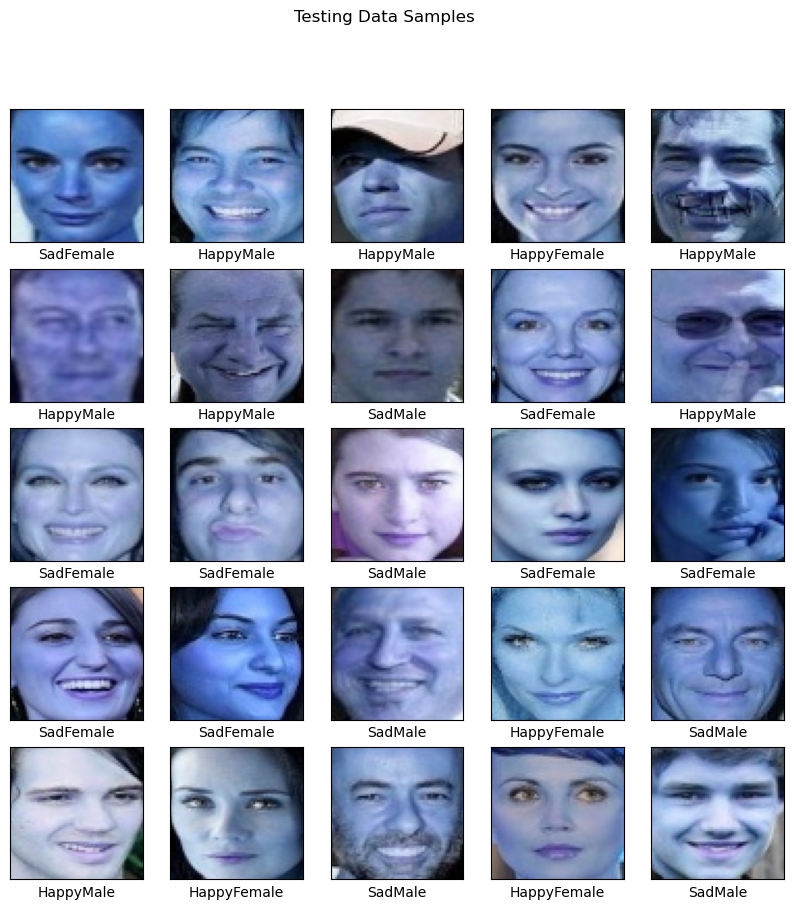

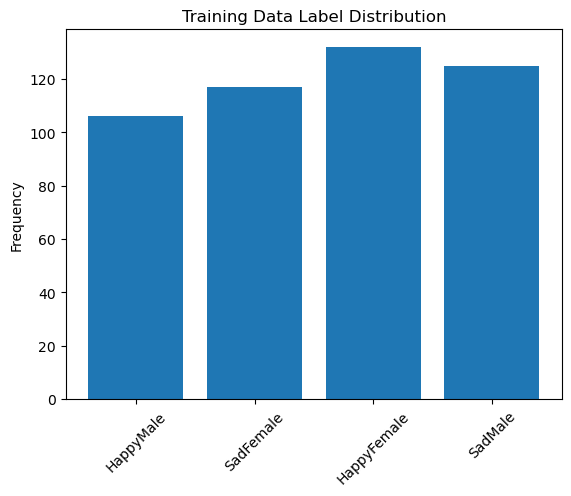

In [66]:
# EDA of Testing Data
test_labels_decoded = [encoder.classes_[np.argmax(label)] for label in test_labels]
plot_sample_images(test_data, test_labels_decoded, 'Testing Data Samples')
plot_label_distribution(test_labels_decoded, 'Testing Data Label Distribution')

5/5 [==============================] - 0s 7ms/step


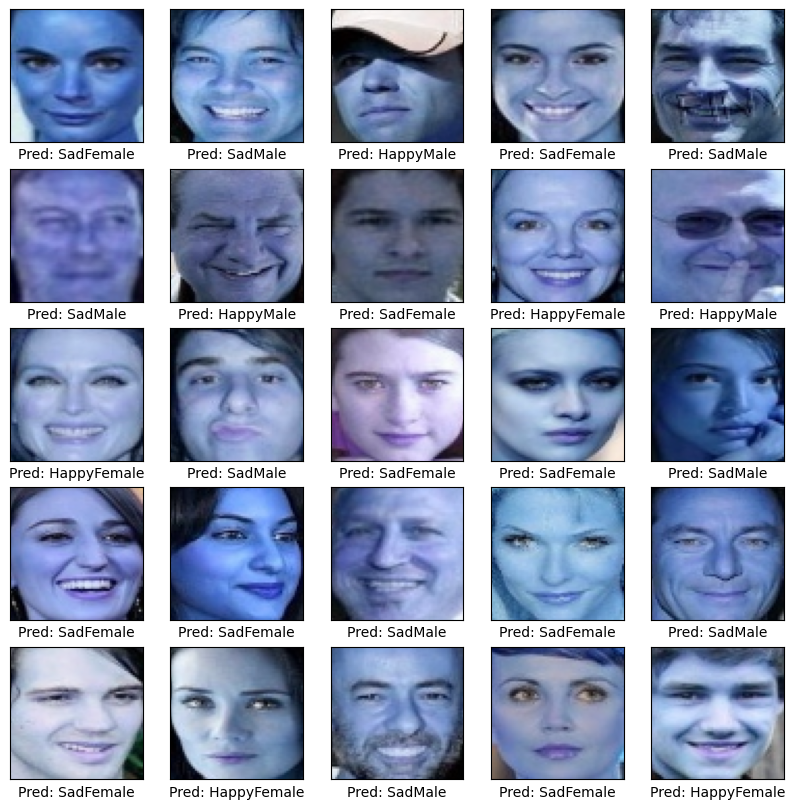

In [67]:


# Predict labels
predicted_label_indices = predict(model_approach2, test_data)
predicted_labels = [encoder.classes_[i] for i in predicted_label_indices]

# Display images with predicted labels
display_predictions(test_data, predicted_labels)
